## https://github.com/plaidml/plaidml

## [Deep Learning without CUDA](https://informatics.sydney.edu.au/blogs/amdgpu/)

## 範例重點

學習如何在 keras 中加入自定義的 callbacks

知道 callback function 可以動作的時機

In [1]:
import os
import keras

# 本範例不需使用 GPU, 將 GPU 設定為 "無"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
"""
# 載入 Callbacks，撰寫一個 f1 score 的 callback function
"""

from keras.callbacks import Callback
from sklearn.metrics import f1_score

class f1sc(Callback):
    def on_train_begin(self, epoch, logs = {}):
        logs = logs or {}
        record_items = ["val_auc", "val_f1sc", "val_fp", "val_fn", "val_tp", "val_tn"]
        for i in record_items:
            if i not in self.params['metrics']:
                self.params['metrics'].append(i)
    
    def on_epoch_end(self, epoch, logs = {}, thres=0.5):
        logs = logs or {}
        y_true = self.validation_data[1].argmax(axis = 1)
        y_pred = self.model.predict(self.validation_data[0])
        y_pred = (y_pred[:, 1] >= thres) * 1
        
        logs["val_f1sc"] = f1_score(y_true = y_true, y_pred = y_pred, average="weighted")
        
log_f1sc = f1sc()

In [8]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[log_f1sc]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

# 在訓練後，將 f1sc 紀錄調出
valid_f1sc = model.history.history['val_f1sc']

W0725 12:39:51.260523 4624979392 deprecation_wrapper.py:119] From /Users/johnsonhuang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0725 12:39:51.286012 4624979392 deprecation_wrapper.py:119] From /Users/johnsonhuang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0725 12:39:51.291883 4624979392 deprecation_wrapper.py:119] From /Users/johnsonhuang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0725 12:39:51.386152 4624979392 deprecation_wrapper.py:119] From /Users/johnsonhuang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.p

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

/Users/johnsonhuang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


50000/50000 [==============================] - 6s 113us/step - loss: 1.7516 - acc: 0.3900 - val_loss: 1.8272 - val_acc: 0.3762
Epoch 3/50
50000/50000 [==============================] - 6s 126us/step - loss: 1.6267 - acc: 0.4296 - val_loss: 1.6983 - val_acc: 0.4081
Epoch 4/50
50000/50000 [==============================] - 6s 111us/step - loss: 1.5530 - acc: 0.4584 - val_loss: 1.6526 - val_acc: 0.4211
Epoch 5/50
50000/50000 [==============================] - 6s 120us/step - loss: 1.4996 - acc: 0.4763 - val_loss: 1.5986 - val_acc: 0.4353
Epoch 6/50
50000/50000 [==============================] - 6s 125us/step - loss: 1.4516 - acc: 0.4926 - val_loss: 1.5704 - val_acc: 0.4458
Epoch 7/50
50000/50000 [==============================] - 7s 142us/step - loss: 1.4112 - acc: 0.5073 - val_loss: 1.5518 - val_acc: 0.4466
Epoch 8/50
50000/50000 [==============================] - 6s 125us/step - loss: 1.3760 - acc: 0.5206 - val_loss: 1.5424 - val_acc: 0.4526
Epoch 9/50
50000/50000 [=====================

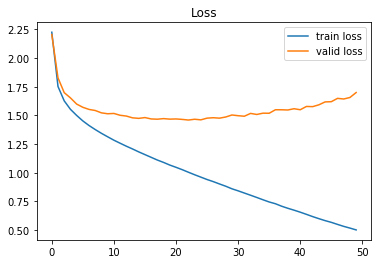

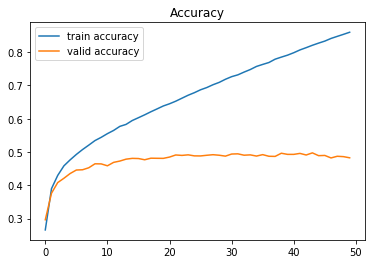

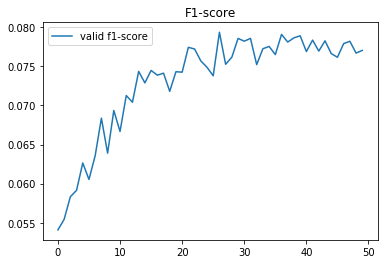

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(range(len(valid_f1sc)), valid_f1sc, label="valid f1-score")
plt.legend()
plt.title("F1-score")
plt.show()

## Work

請嘗試寫一個 callback 用來記錄各類別在訓練過程中，對驗證集的 True Positive 與 True Negative

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
__________

50000/50000 [==============================] - 5s 99us/step - loss: 0.5185 - acc: 0.8510 - val_loss: 1.6640 - val_acc: 0.4828
Epoch 50/50
50000/50000 [==============================] - 5s 98us/step - loss: 0.4990 - acc: 0.8611 - val_loss: 1.6870 - val_acc: 0.4810


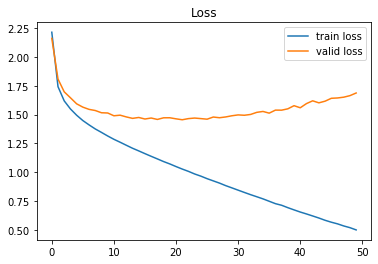

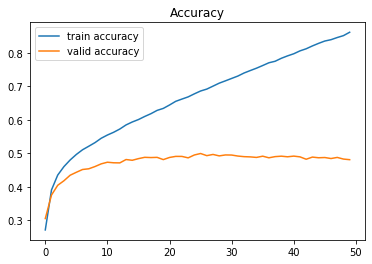

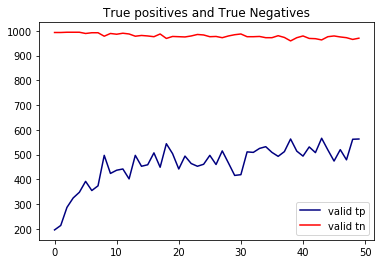

In [3]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""



train, test = keras.datasets.cifar10.load_data()



## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    



x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)



from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    
    
    input_layer = keras.layers.Input(input_shape)
    
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model



## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95



# 載入 Callbacks
from keras.callbacks import Callback
import numpy as np

# Record_fp_tp
class Record_tp_tn(Callback):
    """Code Here
    撰寫一個紀錄 ture positive 與 true negative 數量的 callbacks    
    """
    
    """
    
    https://kawahara.ca/how-to-compute-truefalse-positives-and-truefalse-negatives-in-python-for-binary-classification-problems/
    
    
    # True Positive (TP): we predict a label of 1 (positive), and the true label is 1.
    TP = np.sum(np.logical_and(pred_labels == 1, true_labels == 1))

    # True Negative (TN): we predict a label of 0 (negative), and the true label is 0.
    TN = np.sum(np.logical_and(pred_labels == 0, true_labels == 0))

    # False Positive (FP): we predict a label of 1 (positive), but the true label is 0.
    FP = np.sum(np.logical_and(pred_labels == 1, true_labels == 0))

    # False Negative (FN): we predict a label of 0 (negative), but the true label is 1.
    FN = np.sum(np.logical_and(pred_labels == 0, true_labels == 1))
    
    """
    def on_train_begin(self, epoch, logs = {}):
        logs = logs or {}
        # 驗證集的 True Positive 與 True Negative
        record_items = ["val_tp", "val_tn", "val_fp", "val_fn"]
        for i in record_items:
            if i not in self.params['metrics']:
                self.params['metrics'].append(i)
    
    def on_epoch_end(self, epoch, logs = {}, thres=0.5):
        logs = logs or {}
        # Define y_true, y_pred
        y_true = self.validation_data[1].argmax(axis = 1)
        y_pred = self.model.predict(self.validation_data[0])
        y_pred = (y_pred[:, 1] >= thres) * 1
        # Calculate True Positive, True Negative
        logs["val_tp"] = np.sum(np.logical_and(y_pred == 1, y_true == 1))
        logs["val_tn"] = np.sum(np.logical_and(y_pred == 0, y_true == 0))
        
rec_tptn = Record_tp_tn()



# build model
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()

optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
# compile
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

# fit
"""Code Here
將 callbacks 放入模型訓練流程中
"""
model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[rec_tptn]) # callbacks 紀錄 驗證集的 True Positive 與 True Negative


# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

"""Code Here
將 tp/tn 從訓練完的模型中取出
"""
valid_tp = model.history.history['val_tp']
valid_tn = model.history.history['val_tn']



# plot
import matplotlib.pyplot as plt
%matplotlib inline
# plot loss
plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()
# plot acc
plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()
# plot TP, TN
plt.plot(range(len(valid_tp)), valid_tp, label="valid tp", color="navy")
plt.plot(range(len(valid_tn)), valid_tn, label="valid tn", color="red")
plt.legend()
plt.title("True positives and True Negatives")
plt.show()

## 參考資料


## [紀錄 F1-score 的 callback 實作](https://zhuanlan.zhihu.com/p/51356820)

原生的 Keras 並沒有提供紀錄 F1-score 的方法；在 Sklearn 中計算 F1-score 很容易，有沒有可能將兩個兜在一起?  



寫一個 callback, 它的啟動時機是在每個 epoch 結束時 
呼叫 sklearn 的 f1_score 計算 
將數值寫入 self.val_f1s  


最後在將這個 callback 與其它 callbacks 一起放入 model.fit 就好了。 



![img1](https://ai100-fileentity.cupoy.com/2nd/homework/D88/1563340634350/large)

--

### Keras 中保留 f1-score 最高的模型 (per epoch)

解决方法很简单，Keras 提供了强大的 Callback class，通过继承 Callback，可以实现上面的需求，怎么做呢，如下

以二分类问题为例，

    from sklearn.metrics import f1_score, recall_score, precision_score
    from keras.callbacks import Callback

    def boolMap(arr):
        if arr > 0.5:
            return 1
        else:
            return 0


    class Metrics(Callback):
        def __init__(self, filepath):
            self.file_path = filepath

        def on_train_begin(self, logs=None):
            self.val_f1s = []
            self.best_val_f1 = 0
            self.val_recalls = []
            self.val_precisions = []

        def on_epoch_end(self, epoch, logs=None):
            val_predict = list(map(boolMap, self.model.predict([self.validation_data[0], self.validation_data[1]])))
            val_targ = self.validation_data[2]
            _val_f1 = f1_score(val_targ, val_predict)
            _val_recall = recall_score(val_targ, val_predict)
            _val_precision = precision_score(val_targ, val_predict)
            self.val_f1s.append(_val_f1)
            self.val_recalls.append(_val_recall)
            self.val_precisions.append(_val_precision)
            print(_val_f1, _val_precision, _val_recall)
            print("max f1")
            print(max(self.val_f1s))
            if _val_f1 > self.best_val_f1:
                self.model.save_weights(self.file_path, overwrite=True)
                self.best_val_f1 = _val_f1
                print("best f1: {}".format(self.best_val_f1))
            else:
                print("val f1: {}, but not the best f1".format(_val_f1))
            return
        
        
使用方法也很简单，

metrics = Metrics(file_path)

callbacks_list = [metrics]


把这个 callback_list 加入 model 的训练过程就行。